# MTGO Decklists WordCloud


Magic: The Gathering Online frequently publishes decklists that performed well in their tournaments.  
A large portion of the playerbase enjoy [reading and discussing the current metagame of the game](https://www.reddit.com/r/ModernMagic/comments/iaz0pz/mtgo_modern_challenge_t32_08152020/), since the smaller of the online tournaments cost a U$10 fee to join. Any information to leverage competitive advantage is relevant.

With that in mind, I figured it would be convenient to have a quicker way to assess the cards you should keep in mind when playing other than skimming through the all the decklists published.

## Scraping the website

Those decklists are published [here.](https://magic.wizards.com/en/content/deck-lists-magic-online-products-game-info)  
Luckily, the decklists pages follow the same template.

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
url = 'https://magic.wizards.com/en/articles/archive/mtgo-standings/modern-challenge-2020-08-16'

site_data = requests.get(url)
soup = BeautifulSoup(site_data.content)

After inspecting their URL, we can scrape the data.

Let's begin by building a list with every card being listed.  
Since we're interested in the number of copies of each card, we'll have to consider the number of copies _n_ of each card and input it _n_ times.

In [3]:
# Since there are 4 views (the "sort by" parameter), we choose only one.
# Otherwise, we'll have everything multiplied by 4.
containers = soup.find_all('div', attrs={'class': 'sorted-by-overview-container'})

# Each decklist is contained in one of those divs.
decklists = [container.find_all('span', attrs={'class': 'row'}) for container in containers]

card_list = list()
for decklist in decklists:
    for card in decklist:
        card_name = card.find('span', attrs={'class': 'card-name'}).get_text()
        copies = int(card.find('span', attrs={'class': 'card-count'}).get_text())
        card_list.extend(copies * [card_name])

print(card_list)

['Karn Liberated', 'Karn Liberated', 'Karn Liberated', 'Karn Liberated', 'Karn, the Great Creator', 'Karn, the Great Creator', 'Karn, the Great Creator', 'Karn, the Great Creator', 'Ugin, the Ineffable', 'Ugin, the Ineffable', 'Ugin, the Spirit Dragon', 'Ugin, the Spirit Dragon', 'Emrakul, the Promised End', 'Ulamog, the Ceaseless Hunger', 'Ulamog, the Ceaseless Hunger', 'Walking Ballista', 'Walking Ballista', 'Walking Ballista', 'Wurmcoil Engine', 'Wurmcoil Engine', 'Wurmcoil Engine', 'Wurmcoil Engine', 'Ancient Stirrings', 'Ancient Stirrings', 'Ancient Stirrings', 'Ancient Stirrings', 'Sylvan Scrying', 'Sylvan Scrying', 'Sylvan Scrying', 'Sylvan Scrying', 'Chromatic Sphere', 'Chromatic Sphere', 'Chromatic Sphere', 'Chromatic Sphere', 'Chromatic Star', 'Chromatic Star', 'Chromatic Star', 'Chromatic Star', 'Expedition Map', 'Expedition Map', 'Expedition Map', 'Expedition Map', 'Blast Zone', 'Sanctum of Ugin', 'Snow-Covered Forest', 'Snow-Covered Forest', 'Snow-Covered Forest', 'Snow-Co

## Building the wordcloud

It's easier to build the wordcloud from the frequencies.  
That way we don't have to deal with collocations (bigrams) or other _n_-words terms.

The `Counter` object from collections is perfect for that.

In [4]:
from collections import Counter

card_counter = Counter(card_list)
print(card_counter)

Counter({'Lightning Bolt': 48, 'Misty Rainforest': 32, 'Bloodstained Mire': 26, 'Snow-Covered Forest': 25, 'Wooded Foothills': 25, 'Force of Negation': 24, 'Growth Spiral': 24, 'Monastery Swiftspear': 24, "Mishra's Bauble": 24, 'Mountain': 24, "Uro, Titan of Nature's Wrath": 23, 'Thoughtseize': 23, 'Inquisition of Kozilek': 23, 'Fatal Push': 23, 'Remand': 22, 'Island': 22, 'Blackcleave Cliffs': 22, 'Scalding Tarn': 21, 'Cryptic Command': 20, 'Breeding Pool': 19, 'Snow-Covered Island': 18, 'Sunbaked Canyon': 17, 'Path to Exile': 16, 'Soul-Scar Mage': 16, 'Aether Vial': 16, 'Windswept Heath': 16, 'Karn, the Great Creator': 15, 'Field of the Dead': 15, 'Forest': 15, 'Polluted Delta': 15, 'Manamorphose': 15, 'Field of Ruin': 14, 'Flooded Strand': 14, 'Verdant Catacombs': 14, 'Mystic Sanctuary': 13, 'Lava Dart': 13, 'Expedition Map': 12, "Urza's Mine": 12, "Urza's Power Plant": 12, "Urza's Tower": 12, 'Abbot of Keral Keep': 12, 'Cling to Dust': 12, 'Blood Crypt': 12, 'Tarmogoyf': 12, 'Horiz

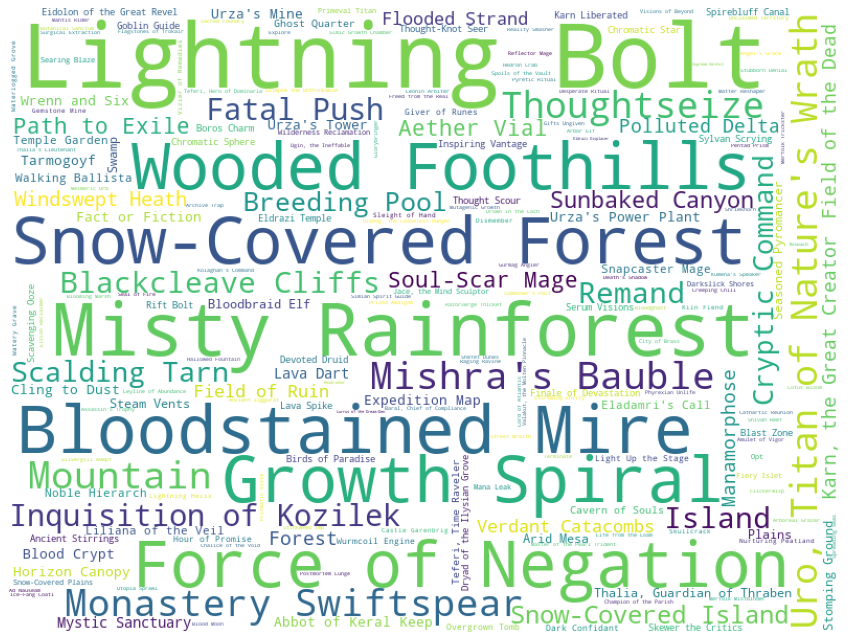

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


cloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    ).generate_from_frequencies(card_counter)

plt.figure(figsize = (15,15))
plt.imshow(cloud)
plt.axis("off")
plt.show()

Looking good. But can we make it easier to notice the best colors in the format?

## Recoloring

Since each card represents a color (it could be multicolored or colorless as well), it would be more informative if we could set each card to its own color.

There's a gallery of examples in the wordcloud documentation page.  
I took their piece of code to choose the exact colors.

In [6]:
# http://amueller.github.io/word_cloud/auto_examples/colored_by_group.html
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

## Extracting card colors

We're lucky. The decklists have an option to sort by color, and the divs are pretty convenient to scrape by color.

In [7]:
colors = ['white', 'blue', 'black', 'red', 'green', 'multi', 'colorless']
color_to_words = dict()
for color in colors:
    cards = list()
    for decklist in soup.find_all('div', attrs={'class': f'sorted-by-{color}'}):
        for card in decklist.find_all('span', attrs={'class': 'card-name'}):
            cards.append(card.get_text())
    color_to_words[color] = cards
    
print(color_to_words)

{'white': ['Path to Exile', 'Celestial Purge', 'Timely Reinforcements', 'Flickerwisp', 'Giver of Runes', 'Leonin Arbiter', 'Stoneforge Mystic', 'Thalia, Guardian of Thraben', 'Thalia, Heretic Cathar', 'Path to Exile', 'Aven Mindcensor', 'Containment Priest', 'Gideon, Ally of Zendikar', 'Kor Firewalker', 'Leonin Relic-Warder', 'Mirran Crusader', 'Rest in Peace', 'Winds of Abandon', 'Champion of the Parish', 'Thalia, Guardian of Thraben', "Thalia's Lieutenant", 'Auriok Champion', 'Aven Mindcensor', 'Giver of Runes', 'Vizier of Remedies', 'Burrenton Forge-Tender', 'Path to Exile', "Angel's Grace", 'Phyrexian Unlife', 'Leyline of Sanctity', 'Path to Exile', 'Wall of Omens', 'Path to Exile', 'Celestial Purge', 'Timely Reinforcements', 'Path to Exile', 'Timely Reinforcements', 'Thalia, Guardian of Thraben', 'Aven Mindcensor', 'Celestial Purge', 'Eidolon of Rhetoric', 'Path to Exile', "Heliod's Pilgrim", 'Vizier of Remedies', 'Auriok Champion', 'Burrenton Forge-Tender', 'Celestial Purge', 'Ko

I opened some cards in [Gimp](https://www.gimp.org/) and picked the colors.

In [8]:
# renaming colors
color_to_words['#fcfcc1'] = color_to_words.pop('white')
color_to_words['#67c1f5'] = color_to_words.pop('blue')
color_to_words['#846484'] = color_to_words.pop('black')
color_to_words['#f85555'] = color_to_words.pop('red')
color_to_words['#26b569'] = color_to_words.pop('green')
color_to_words['#cfaa4a'] = color_to_words.pop('multi')
color_to_words['#6b5441'] = color_to_words.pop('colorless')

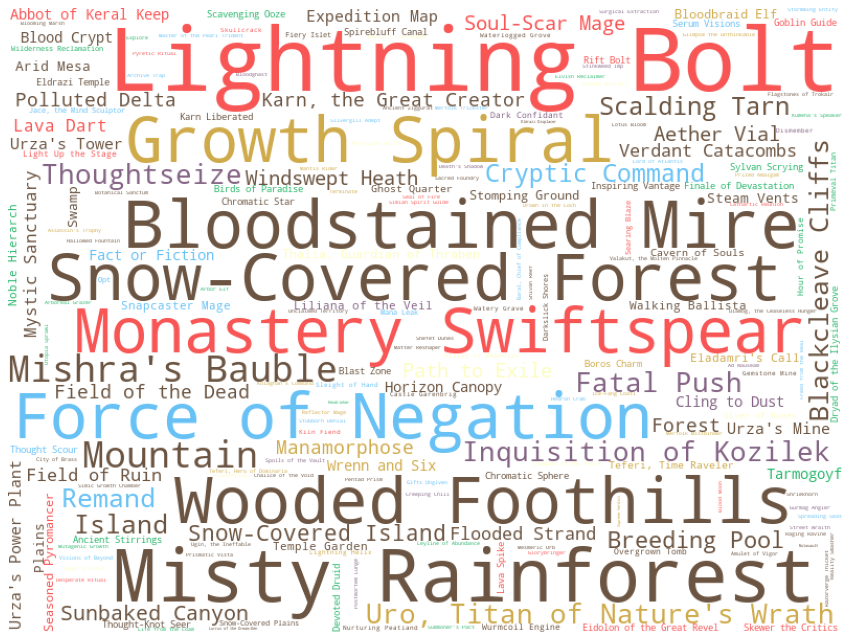

In [9]:
cloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    ).generate_from_frequencies(card_counter)


grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color='black')

# Apply our color function
cloud.recolor(color_func=grouped_color_func)


plt.figure(figsize = (15,15))
plt.imshow(cloud)
plt.axis("off")
plt.show()

It worked!  
But the lands are a bit too distracting and they don't give us as much information. Let's filter them.

Oh, and the white is basically invisible. Maybe we should try other background colors.

## Cleaning a little bit

We can conveniently sort by card types too!

In [10]:
lands_list = set()
for decklist in soup.find_all('div', attrs={'class': 'sorted-by-land'}):
    for card in decklist.find_all('span', attrs={'class': 'card-name'}):
        lands_list.add(card.get_text())

print(lands_list)

{'Snow-Covered Island', 'Stomping Ground', 'Wooded Foothills', 'Snow-Covered Swamp', 'Bojuka Bog', 'Tolaria West', 'Hanweir Battlements', 'Snow-Covered Forest', 'Field of Ruin', 'Blackcleave Cliffs', 'Temple Garden', 'Copperline Gorge', 'Dryad Arbor', 'Arid Mesa', 'Oboro, Palace in the Clouds', 'Ancient Ziggurat', 'Mutavault', 'Prismatic Vista', 'Field of the Dead', 'Shivan Reef', 'Swamp', 'Steam Vents', 'Creeping Tar Pit', 'Scalding Tarn', 'Selesnya Sanctuary', 'Flagstones of Trokair', 'Gruul Turf', 'Watery Grave', 'Golgari Rot Farm', 'Temple of Deceit', 'Eiganjo Castle', 'Forgotten Cave', 'Bloodstained Mire', 'Eldrazi Temple', 'Vesuva', 'Valakut, the Molten Pinnacle', "Urza's Power Plant", 'Sanctum of Ugin', 'Seachrome Coast', 'Horizon Canopy', 'Scavenger Grounds', 'Sacred Foundry', 'Spirebluff Canal', 'Razorverge Thicket', 'Seaside Citadel', "Urza's Tower", 'Sunbaked Canyon', 'Cavern of Souls', 'Snow-Covered Plains', 'Hissing Quagmire', 'Irrigated Farmland', 'Forest', 'Snow-Covered 

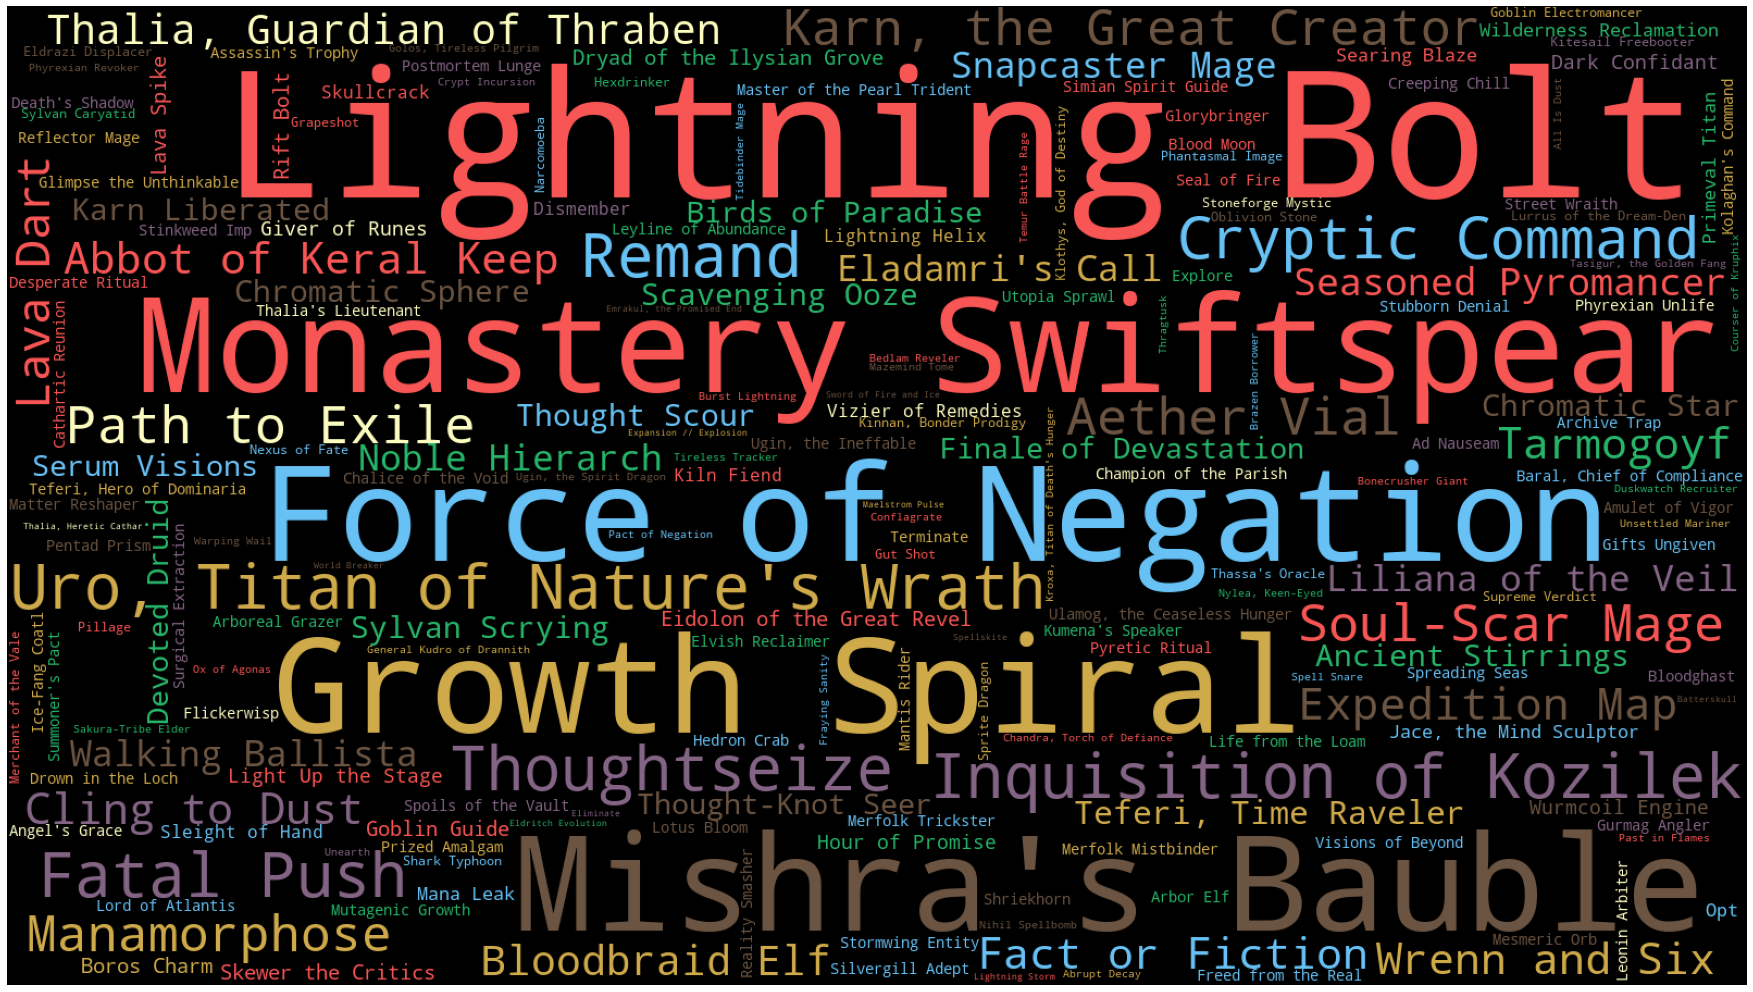

In [11]:
for card in lands_list:
    del card_counter[card]


cloud = WordCloud(
    background_color='black',
    width=1600,
    height=900,
    ).generate_from_frequencies(card_counter)

grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color='black')
cloud.recolor(color_func=grouped_color_func)

plt.figure(figsize = (32,18))
plt.imshow(cloud)
plt.axis("off")
plt.show()

# Conclusion

I'm finally happy with the results!  
I can quickly see that I should be wary of aggressive cards like Lightning Bolt and Monastery Swiftspear, but also be prepared for the grindy games facing Uro, Titan of Nature's Wrath, Growth Spiral, Mishra's Bauble and Force of Negation.